# 0.0. IMPORTS

In [1]:
# Importando pandas e a classe inflection (para organizar os nomes das colunas)
# Importando também numpy para tratar números, seaborn e matplotlib para visualization
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import pandas              as pd
import numpy               as np
import seaborn             as sns
import xgboost             as xgb

import math
import inflection
import datetime

from scipy                 import stats
from IPython.core.display  import display, HTML
from IPython.display       import Image
from boruta                import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1. Helper Functions

In [92]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*7*6 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*7*6 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # storing performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),     
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] ) 

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )
    
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

# criando uma função para utilizar o cramer's várias vezes. JÁ COM A CORREÇÃO, CONSULTAR LINK WIKIPEDIA DO CRAM
def cramer_v ( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = k - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML("<style>.container { width:100% !important; }</style>"))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    
    sns.set()

In [88]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Leonardo Nunciatelli\anaconda3\envs\DataScience_Em_Producao\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [4]:
# Lendo os arquivos CSV utilizando parametro low_memory que ajuda PC's com baixa memória a carregar grandes arquivos
# Se low_memory = False, então ele irá carregar todo o arquivo de uma vez, do contrário carregaria em partes
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Juntando os dois DF's, utilizando "left join" e a coluna "Store" como PK, esta coluna está presente em ambos DF's

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 -  DESCRICAO DOS DADOS

In [5]:
#Criando um DF de cópia de segurança
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
# Guardando as antigas colunas em uma variável para trata-las posteriormente

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# utilizando uma função snakecase que chama a função lambda para chamar o inflection e transformar as colunas em minusculo
# separado por underline _

snakecase = lambda x: inflection.underscore( x )


# função map mapeia tudo da snakecase e pega a lista cols_old guardando a nova lista na variável cols_new
cols_new = list( map( snakecase, cols_old ) )

# passando as colunas cols_new para o DF1
df1.columns =  cols_new

## 1.2. Data Dimensions

In [7]:
# Apenas printa a quantidade de linhas e coluna do DF
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
# Tipos de dados em cada coluna do DF
# Observando a coluna Date que é um Object (Object = string no pandas, tudo que não for INT o pandas transforma em Object)
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# Utilizando a função to_datetime para converter a coluna date para datetime
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [10]:
# Checando se possui alguma coluna com linha vazia e somando o total em cada coluna

# existem 3 formas de tratar NA
#   1- Eliminar as linhas que possuem NA
#   2- Usar algoritmo de ML para completar esses NA
#   3- Entendendo do negócio para saber o motivo das linhas estarem faltando

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
## aplicando função lambda para aplicar um valor em tudo que é NA e deixar o valor atual nos que possuem algum valor
## Foi feito desta forma pois considera-se que se o concorrente está muito longe, não existe concorrencia, então
## colocou-se um valor muito grande (maior que o máximo existente)
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

## aplicando novamente a função lambda para transferir o valor da coluna date para a as colunas da data de abertura
## dos concorrentes, assim os algoritmos de ML podem utilizar a função para calcular tempos de datas
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

## Mesma lógica do competition_open_since_year, aplicando a data nas linhas NA para poder abastecer futuramente
## os algoritmos de ML
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


## Foi criado um dicionario com os meses, transformando as linhas com NA em 0, inserindo o nome do mês na nova coluna
## chamada month_map de acordo com o nome especificado no dicionário e usando a função lambada, passamos pelas linhas
## inserindo 1 quando o mes da coluna date estiver presente na coluna promo_interval e 0 caso não tenha o mês
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)
             
df1['month_map'] = df1['date'].dt.month.map( month_map )
             
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

In [12]:
# 5 exemplos exibindo em Tabela
df1.sample(5).T

,299510,348624,812925,695696,300363
store,580,54,876,722,479
day_of_week,6,2,3,3,5
date,2014-10-25 00:00:00,2014-09-02 00:00:00,2013-07-03 00:00:00,2013-10-16 00:00:00,2014-10-24 00:00:00
sales,8471,8681,10387,8239,13319
customers,1307,744,1146,1431,1538
open,1,1,1,1,1
promo,0,1,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,1,0
store_type,a,d,a,a,a


In [13]:
#Total de NA ou NaN em cada coluna
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
#Conferindo novamente os tipos de cada coluna
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# Convertendo as colunas que estão em float (decimal) para int64 assim como o restante do DF

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( "int64" )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( "int64" )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( "int64" )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( "int64" )

In [16]:
# Checando se as conversões foram feitas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [18]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
118495,306,4,4547,467,1,1,0,5100.0,4,2007,1,40,2014,1
471364,505,1,6486,743,1,1,0,350.0,5,2014,1,5,2013,1
276725,175,2,4195,616,1,0,0,4130.0,11,2014,0,47,2014,0
893071,742,1,10093,1022,1,1,0,4380.0,4,2013,0,17,2013,0
265692,390,7,0,0,0,0,0,1600.0,4,2009,0,48,2014,0


In [19]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
540862,0,a,a,0,Mar
162681,0,c,c,0,Mar
564950,0,d,c,0,Feb
998245,0,a,c,"Jan,Apr,Jul,Oct",Jan
998188,0,a,a,"Jan,Apr,Jul,Oct",Jan


### 1.7.1. Numerical Attributes

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [21]:
# min = valor mínimo da coluna
# max = valor máximo da coluna
# range = diferença entre mínimo e máximo
# mean = MÉDIA da coluna
# median = 
# std = desvio padrão, pode ser interpretada como margem de erro, std = 100 de uma mean = 300 significa que o valor é entre 200 a 400
# skew = 
# kurtosis = 

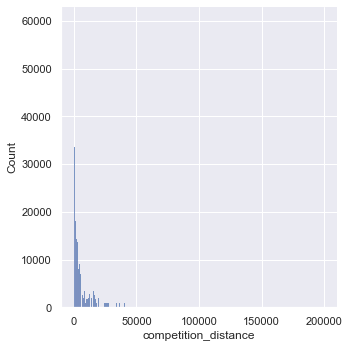

In [22]:
sns.displot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [23]:
# Pegar quantidade de valores únicos em cada coluna
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

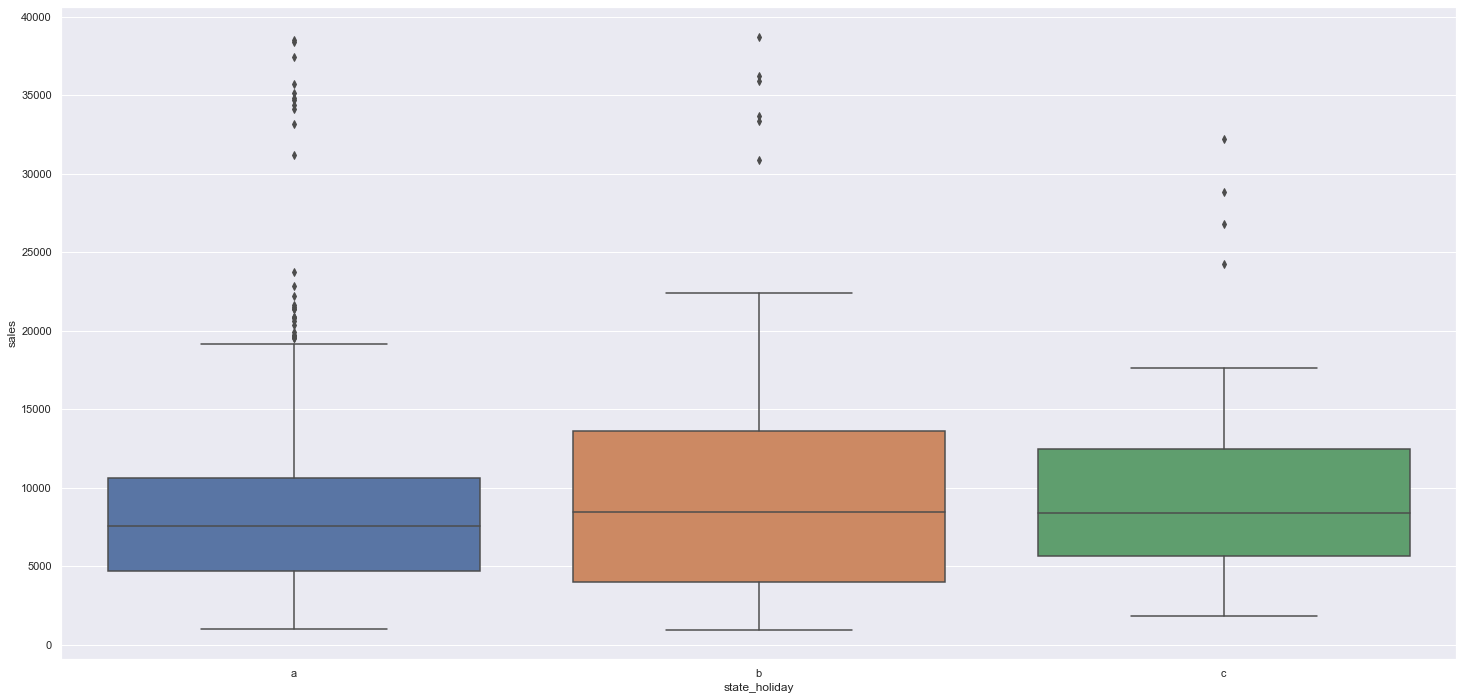

In [24]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

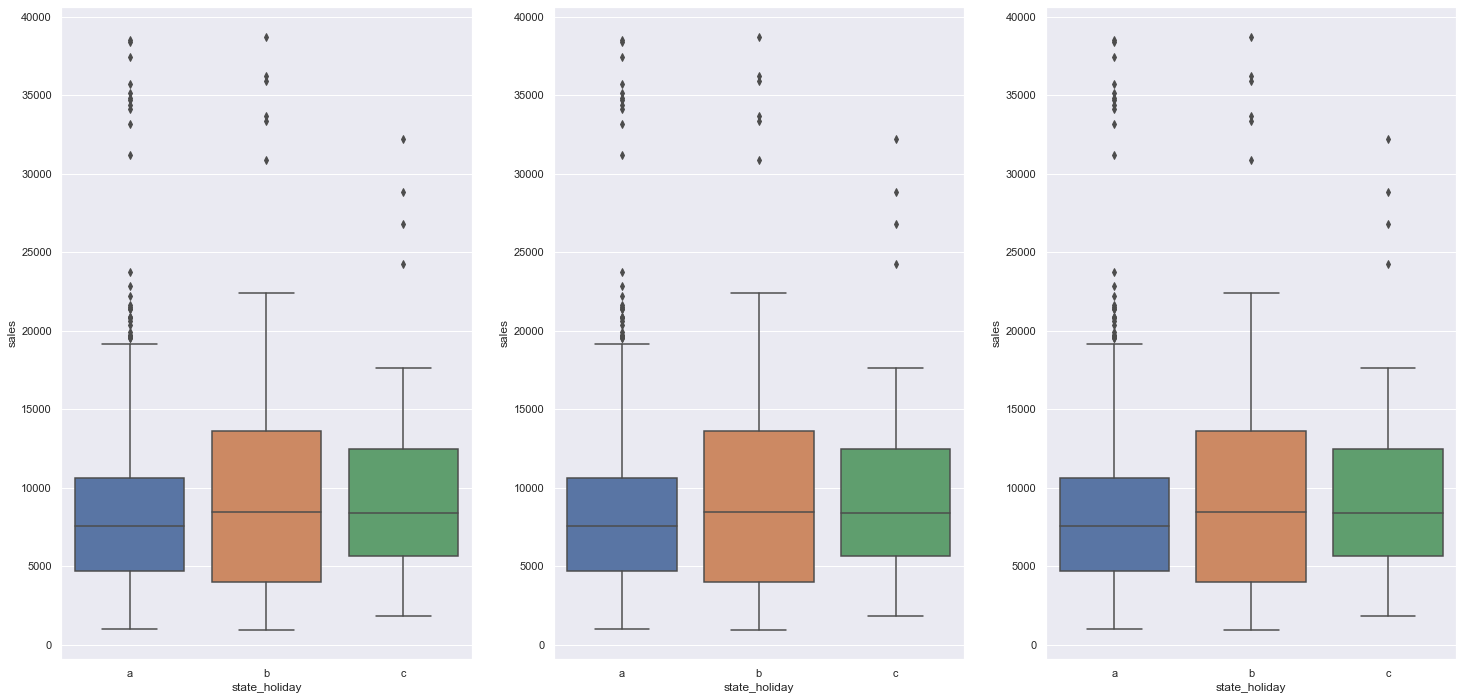

In [25]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

In [26]:
# Descrevendo o boxplot
## A barra mais embaixo significa o menor valor da coluna, enquanto a barra em cima é o maior valor
## No quadrado, o canto inferior é o valor na posição de número 25 enquanto a linha do meio é o 50 e a parte superior do
## quadrado é a posição de número 75
## os pontos pretos são os outliners


# Pesquisar mais sobre boxplot

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [27]:
# Criando uma cópia de segurança no dataframe
df2 = df1.copy()

## 2.1. Mapa Mental de Hipótesis

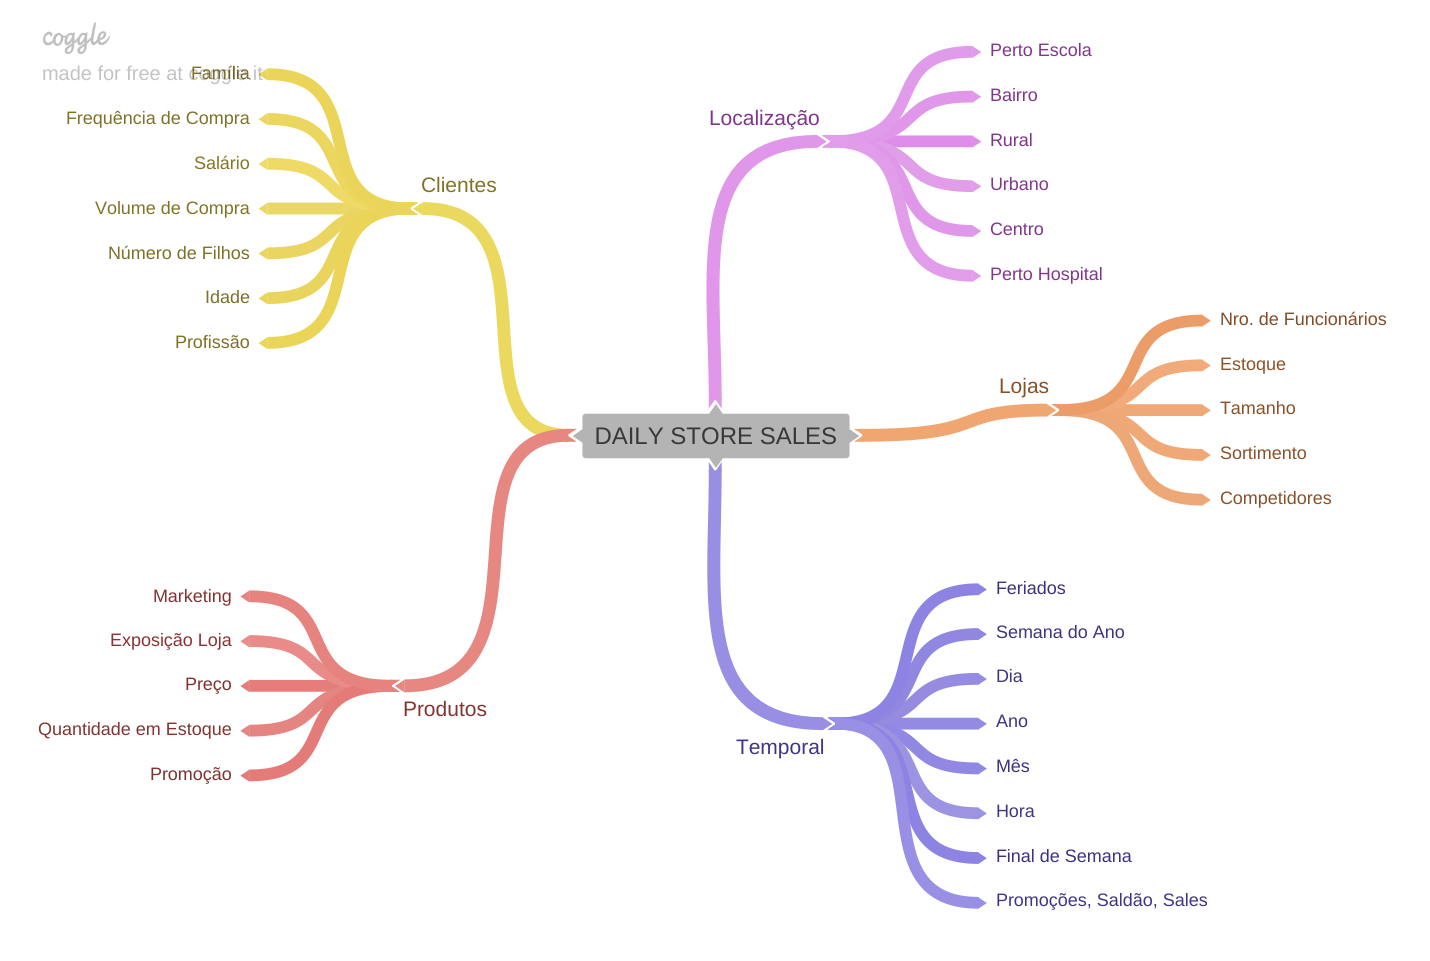

In [28]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação de Hipóteses

### 2.2.1. Hipoteses Loja 

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [29]:
# Criado uma coluna com o ano
df2['year'] = df2['date'].dt.year

# Criando uma colunai com o mes
df2['month'] = df2['date'].dt.month

# Criando uma coluna com o dia
df2['day'] = df2['date'].dt.day

# Criando uma coluna com o numero da semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Criando uma coluna com ano-semana
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Criando uma coluna com a junção do ano e mes, pois estavam separados utilizando sempre o dia 1 de cada mês
# Criando outra coluna com a qtde de meses que existe uma competição próxima
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# Criando uma coluna para juntar as informações de data inicial da promoção
# e outra coluna para contar quantas semanas a promoção está ativa
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days  ).astype( int ) 

# Melhorando os valores da coluna assortment para facilitar a leitura
df2['assortment'] =  df2['assortment'].apply( lambda x: 'basic' if x ==  'a' else 'extra' if x == 'b' else 'extended' )

# Melhorando os valores da coluna state_holiday para facilitar a leitura
df2['state_holiday'] =  df2['state_holiday'].apply( lambda x: 'public_holiday' if x ==  'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [30]:
# Método Head com transpose para verificar as alterações
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS 

In [31]:
# Criando um cópia de segurança
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Lihas 

In [33]:
# Selecionando apenas linhas de lojas que estavam abertas e tiveram alguma venda
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Seleção das Colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [36]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable 

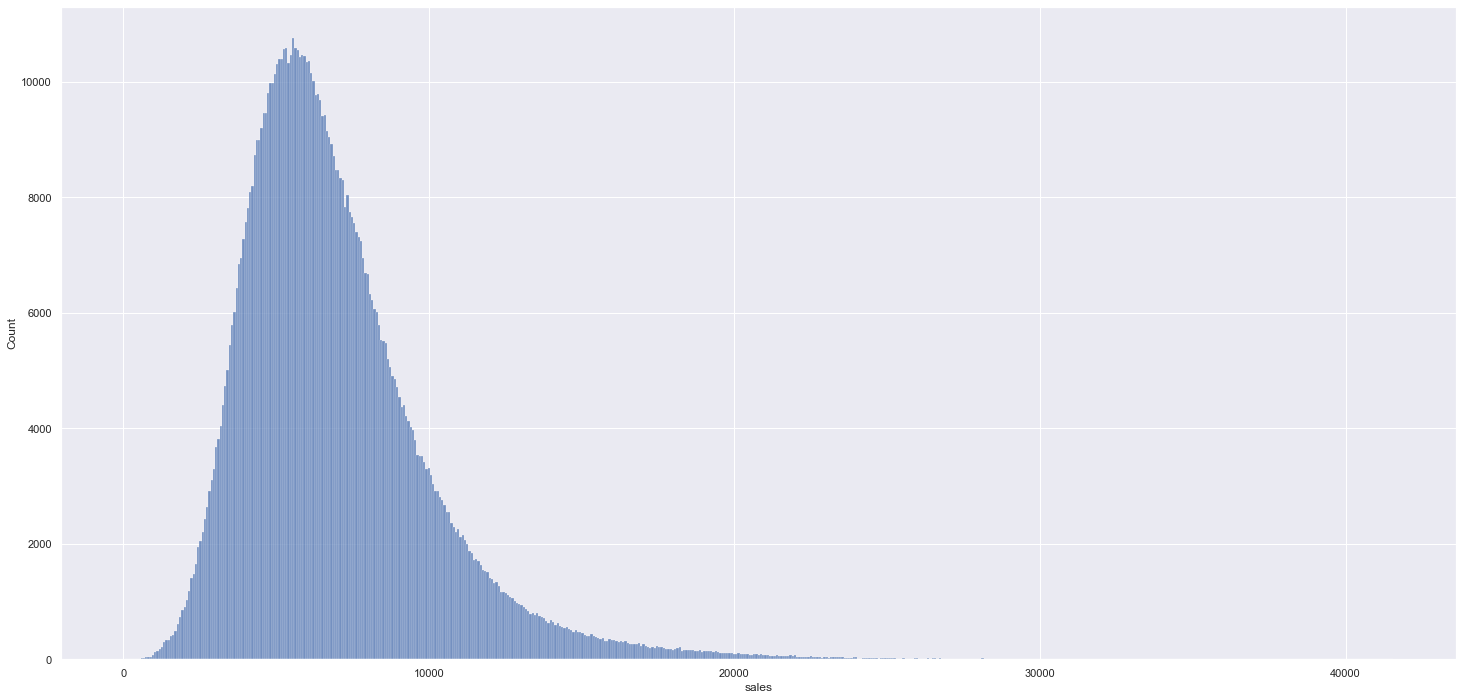

In [37]:
sns.histplot( df4['sales'] );

### 4.1.2. Numerical Variable

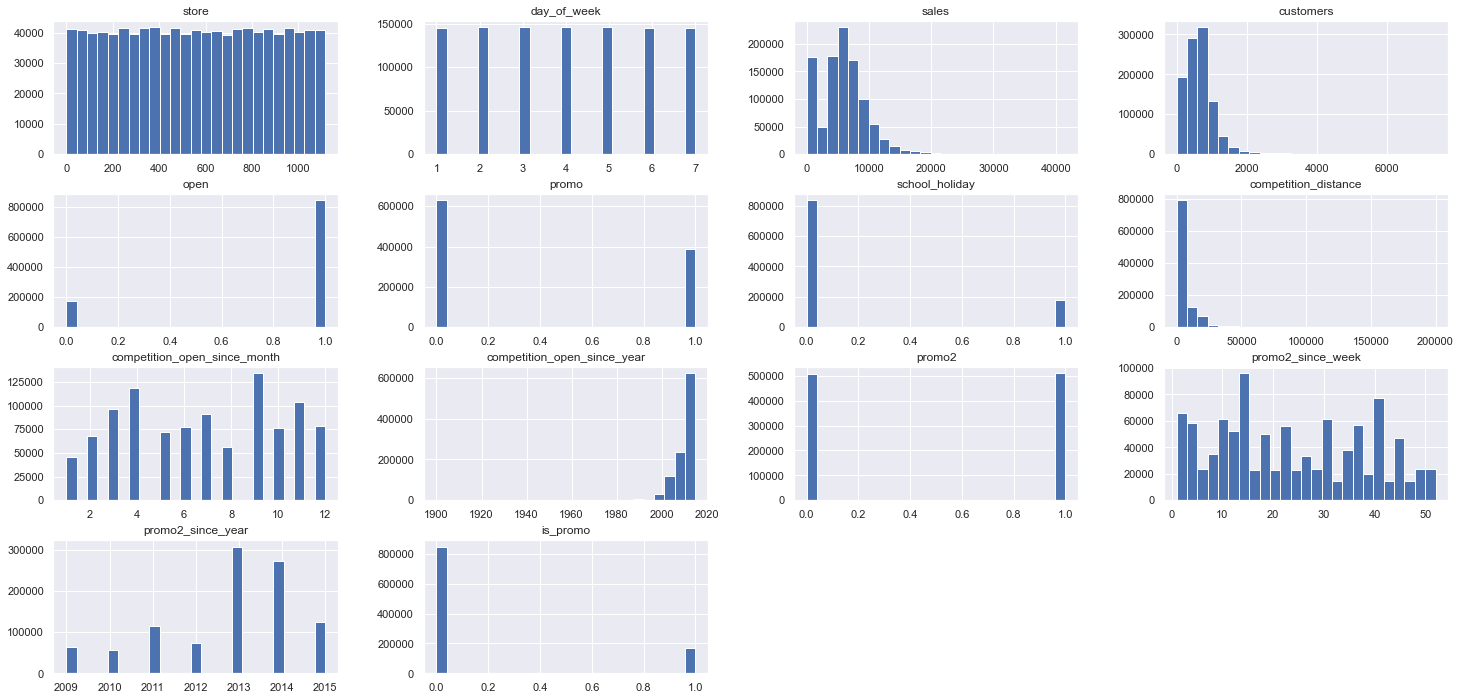

In [38]:
num_attributes.hist( bins=25 );

# Elaborar explicações do negócio se baseando nos gráficos abaixo

### 4.1.3. Categorical Variable

In [39]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\Leonardo Nunciatelli\anaconda3\envs\DataScience_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Leonardo Nunciatelli\anaconda3\envs\DataScience_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Leonardo Nunciatelli\anaconda3\envs\DataScience_Em_Producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other 

<AxesSubplot:xlabel='sales', ylabel='Density'>

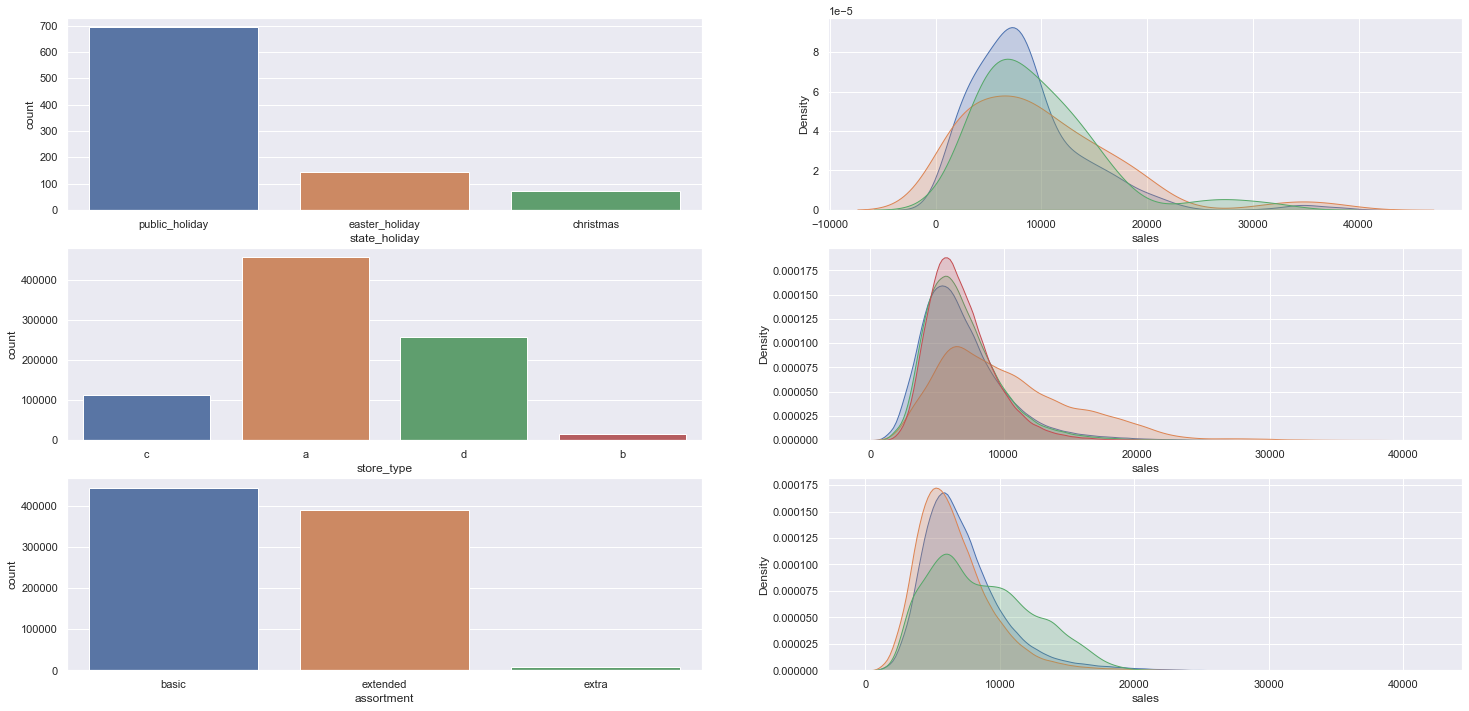

In [40]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True) 


# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True) 


# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Análise Bivariada 

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

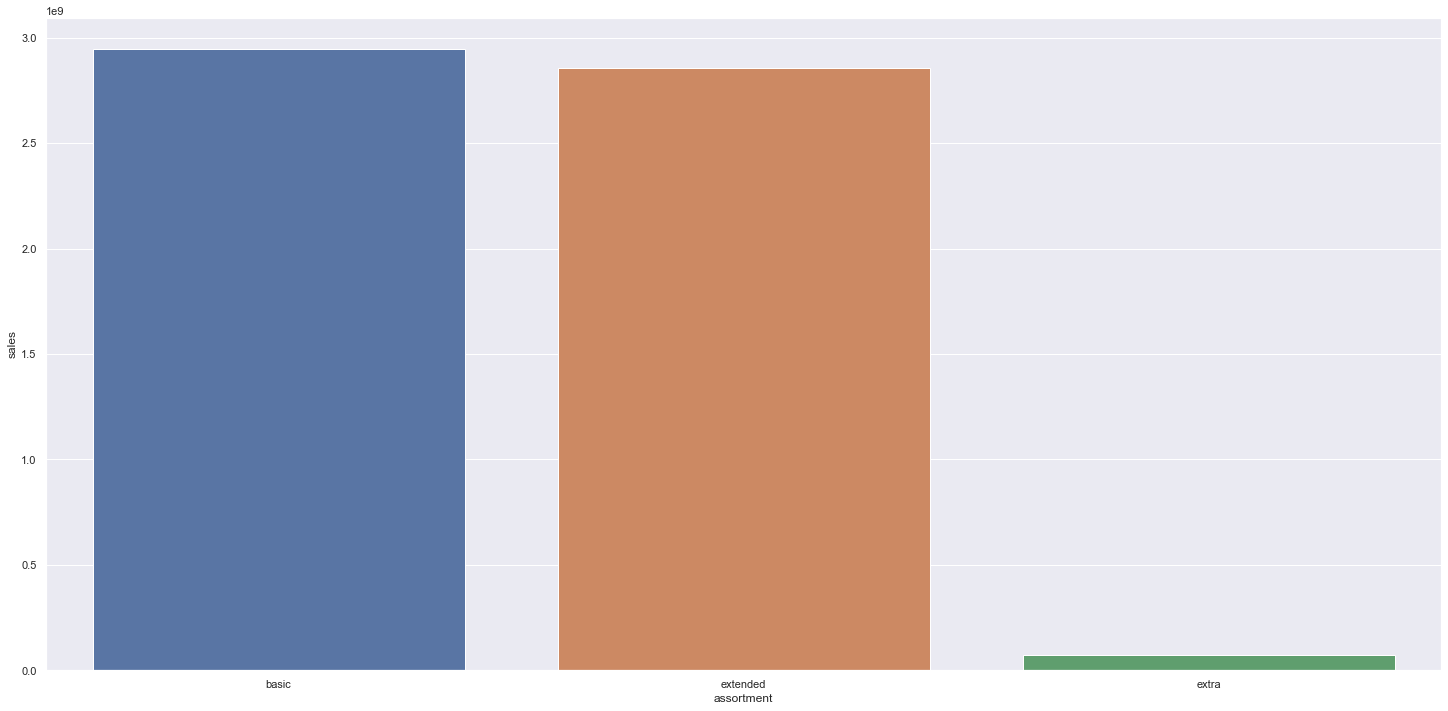

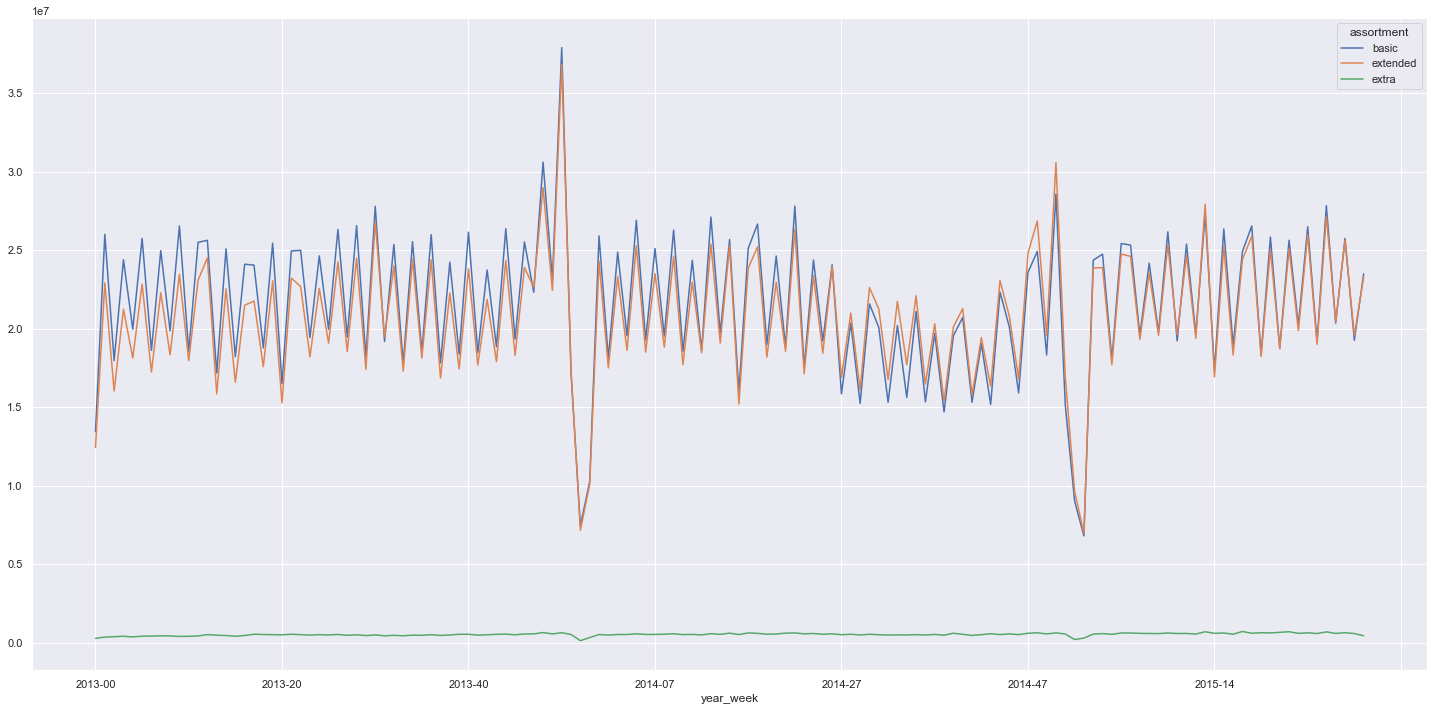

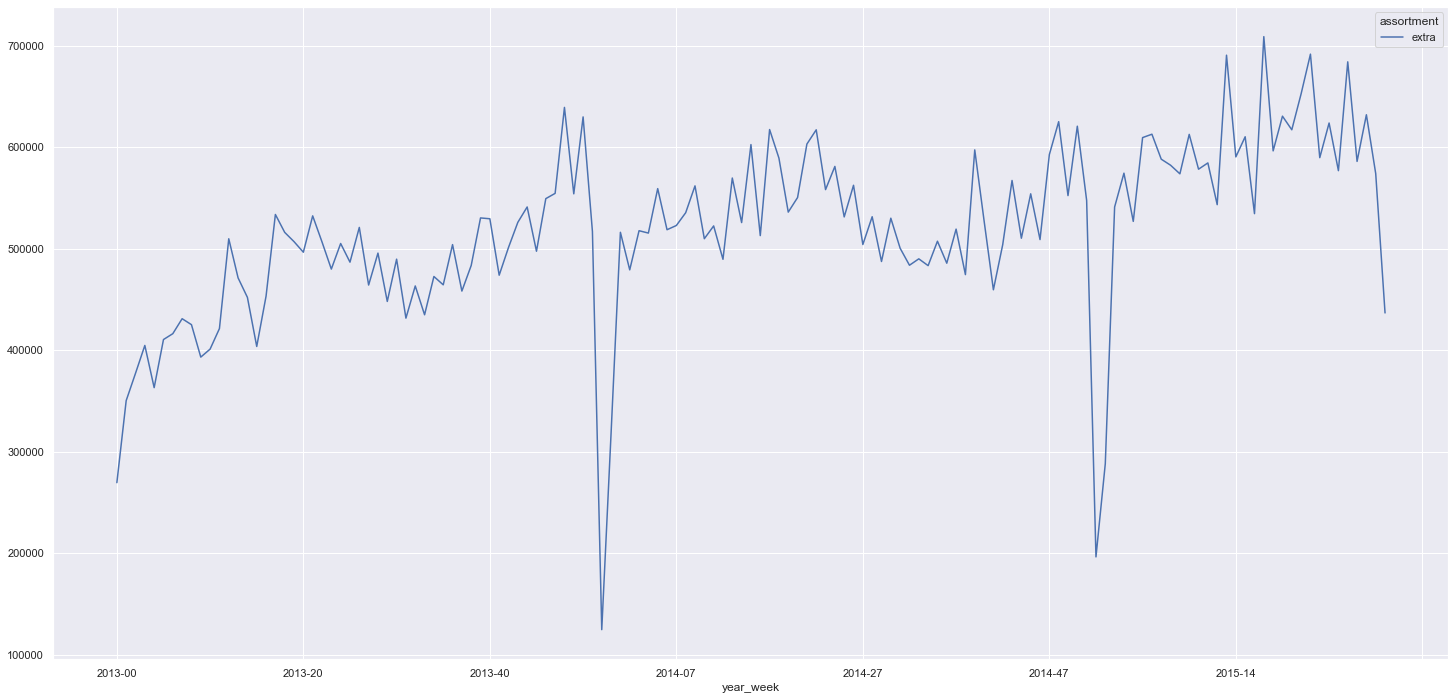

In [41]:
# Criando barplot agrupando pelos tipos de assortment
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# Criando plot para verificar se possui alguma variação ao longo do tempo (principalmente o assortment extra)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# Verificando o comportamento real do assortment extra separado, pois como os valores estavam muito discrepantes, ficou ruim de visualizar com os assortments juntos
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

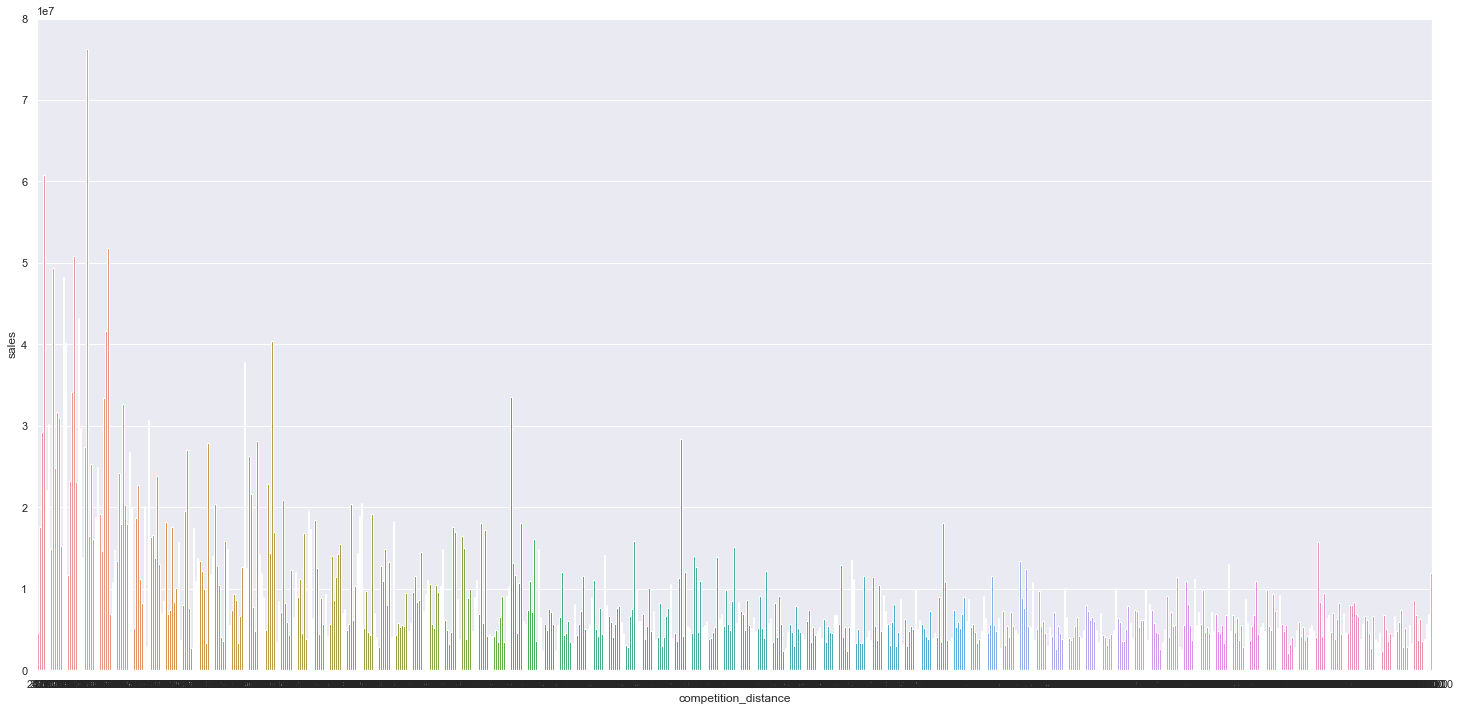

In [42]:
# Gerar barplot agrupando as vendas pela competition_distance
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot( x='competition_distance', y='sales', data=aux1 );

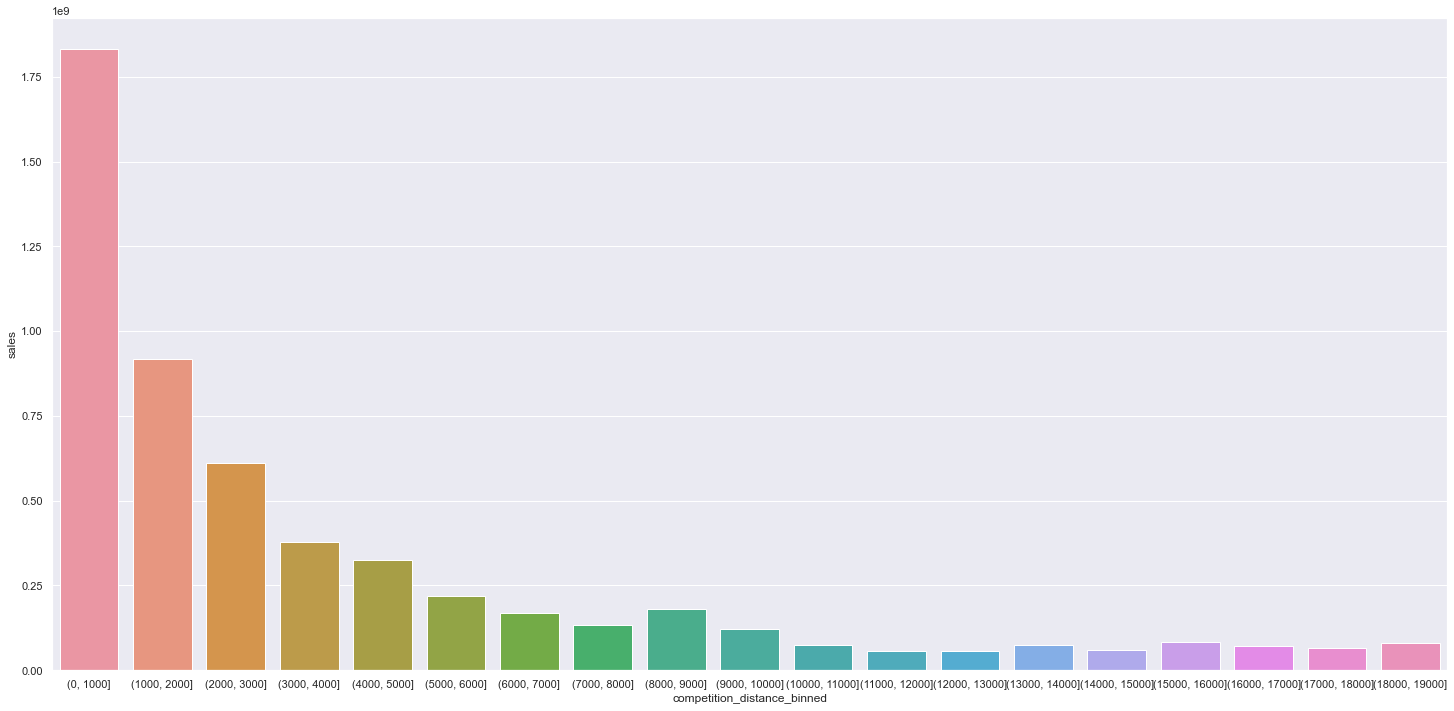

In [43]:
# como o gráfico ficou muito granulado e difícil de visualizar, vamos agrupar de forma mais clara as vendas baseando-se na distância
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list( np.arange( 0, 20000, 1000 ) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()


sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

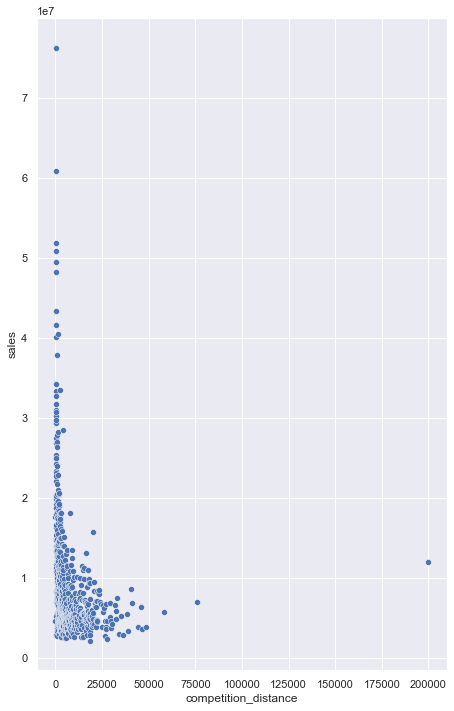

In [44]:
# Criando um gráfico do tipo scatterplot para facilitar um pouco a visualização de dados muito granulados
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

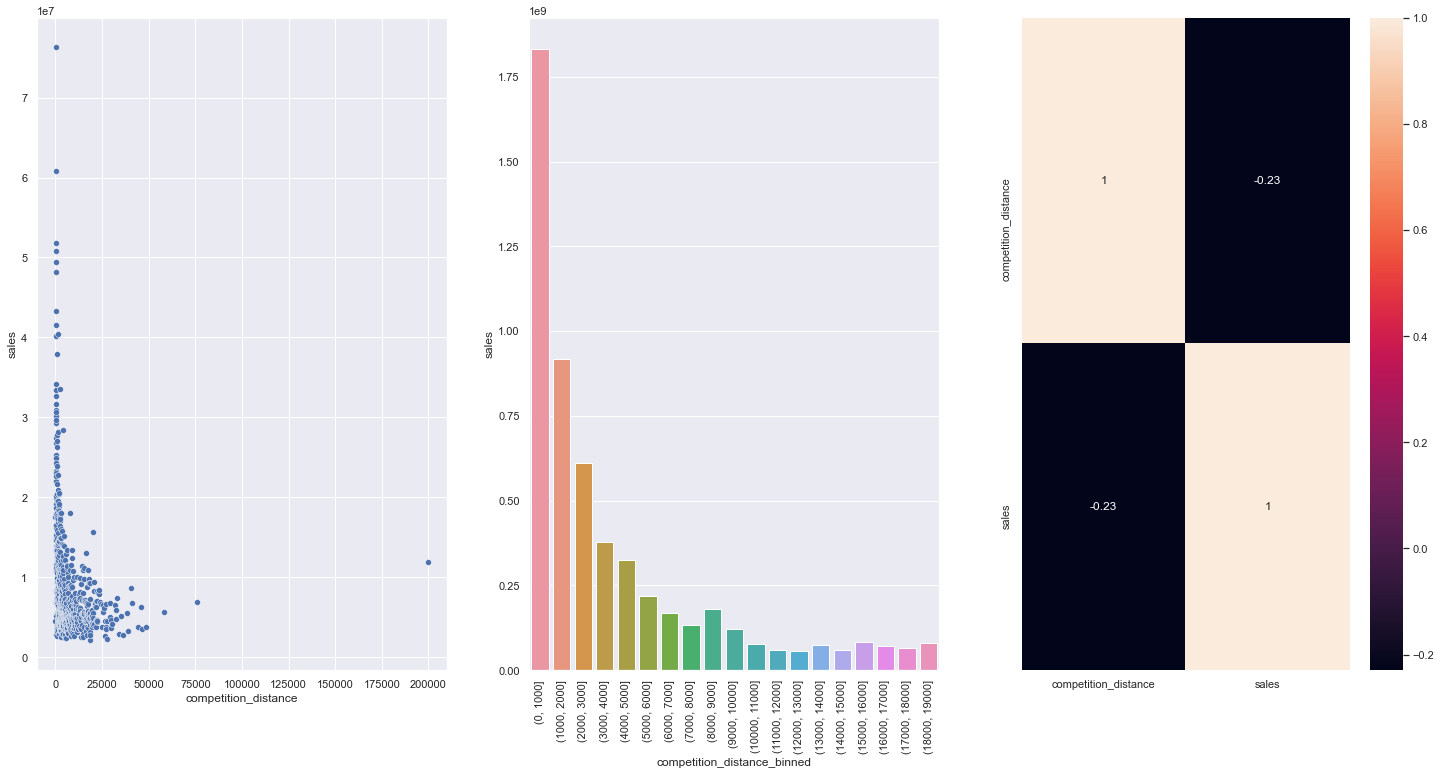

In [45]:
# como o gráfico ficou muito granulado e difícil de visualizar, vamos agrupar de forma mais clara as vendas baseando-se na distância
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES à MAIS TEMPO vendem MENOS.

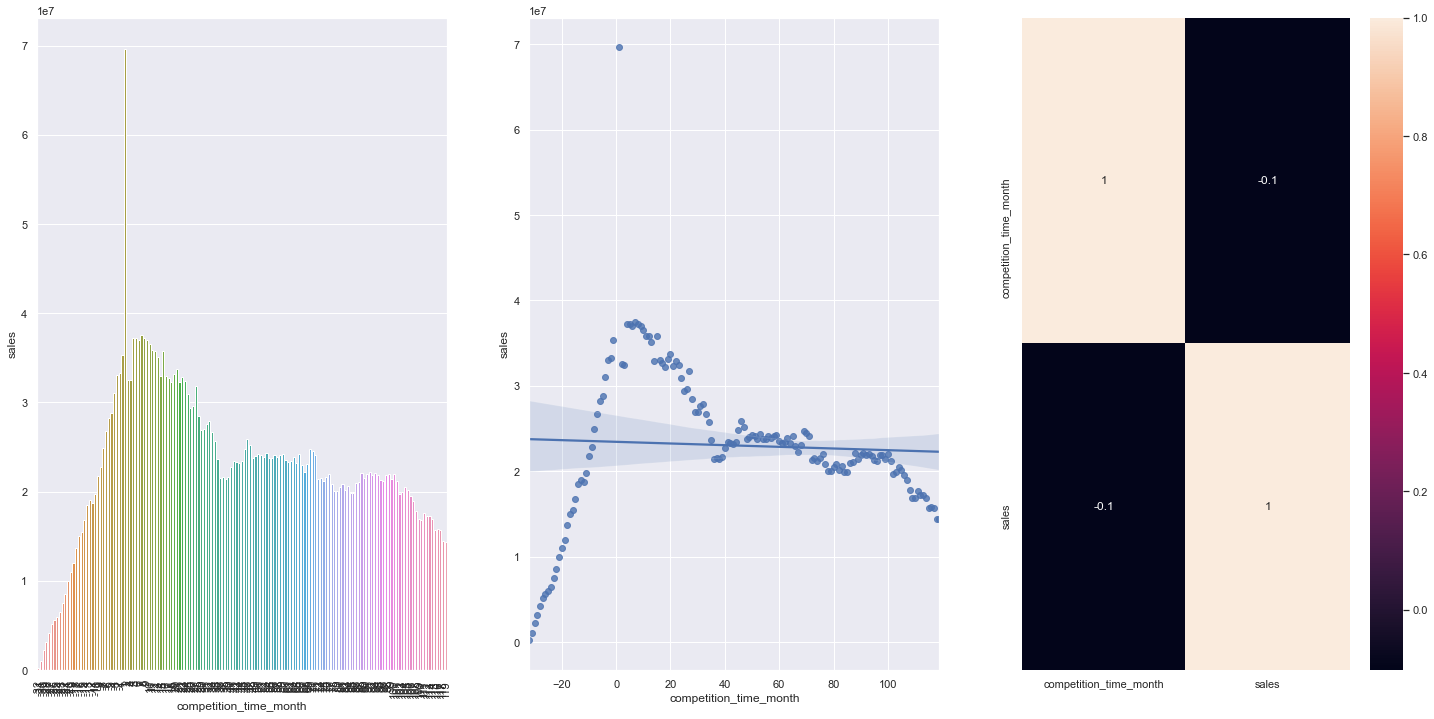

In [46]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com PROMOÇÕES ATIVAS por MAIS TEMPO vendem MENOS depois de um certo período de promoção

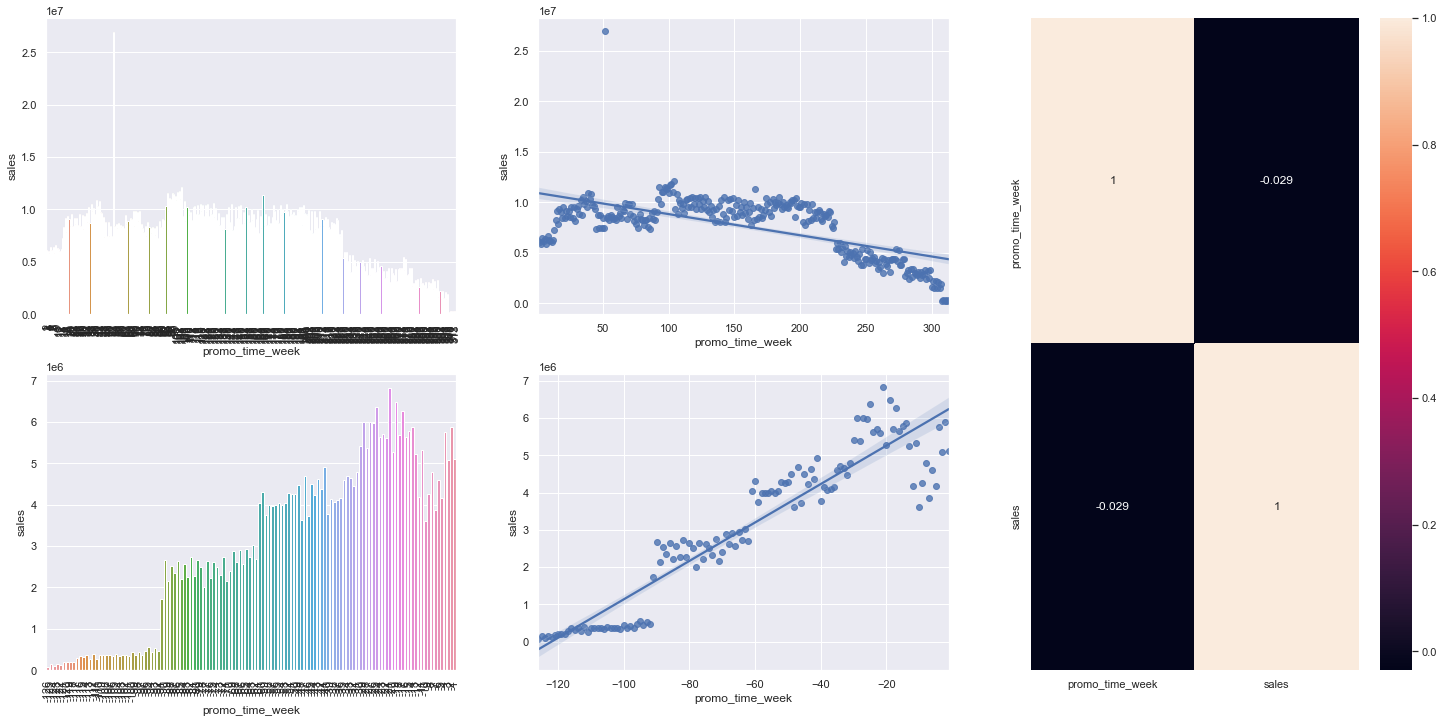

In [47]:
# Criando gráficos para visualizar as tendencias de sales com relação a promo_time_week e a correlação das variáveis com a sales
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = gridspec.GridSpec( 2, 3 ) 

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] #Promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] #Promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS.

In [48]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


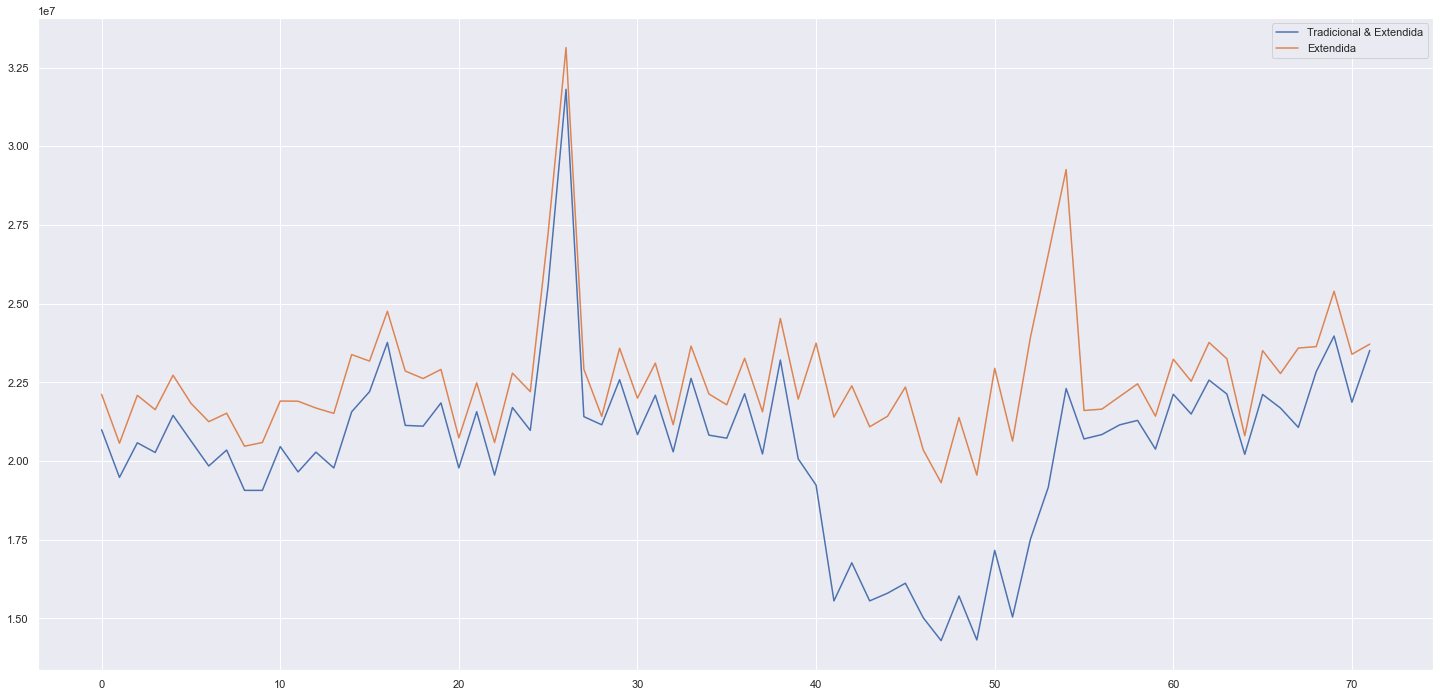

In [49]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=['Tradicional & Extendida', 'Extendida'] );

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem menos.

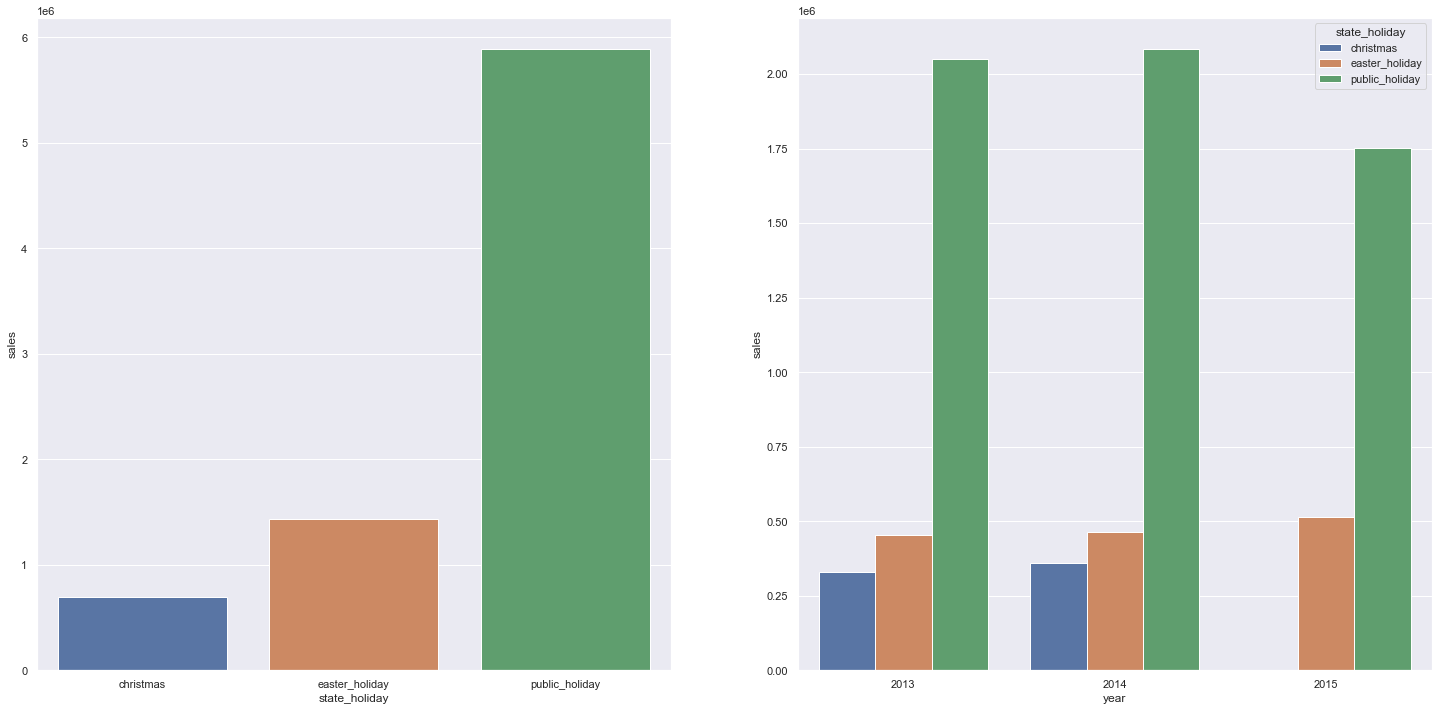

In [50]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

### H8.Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

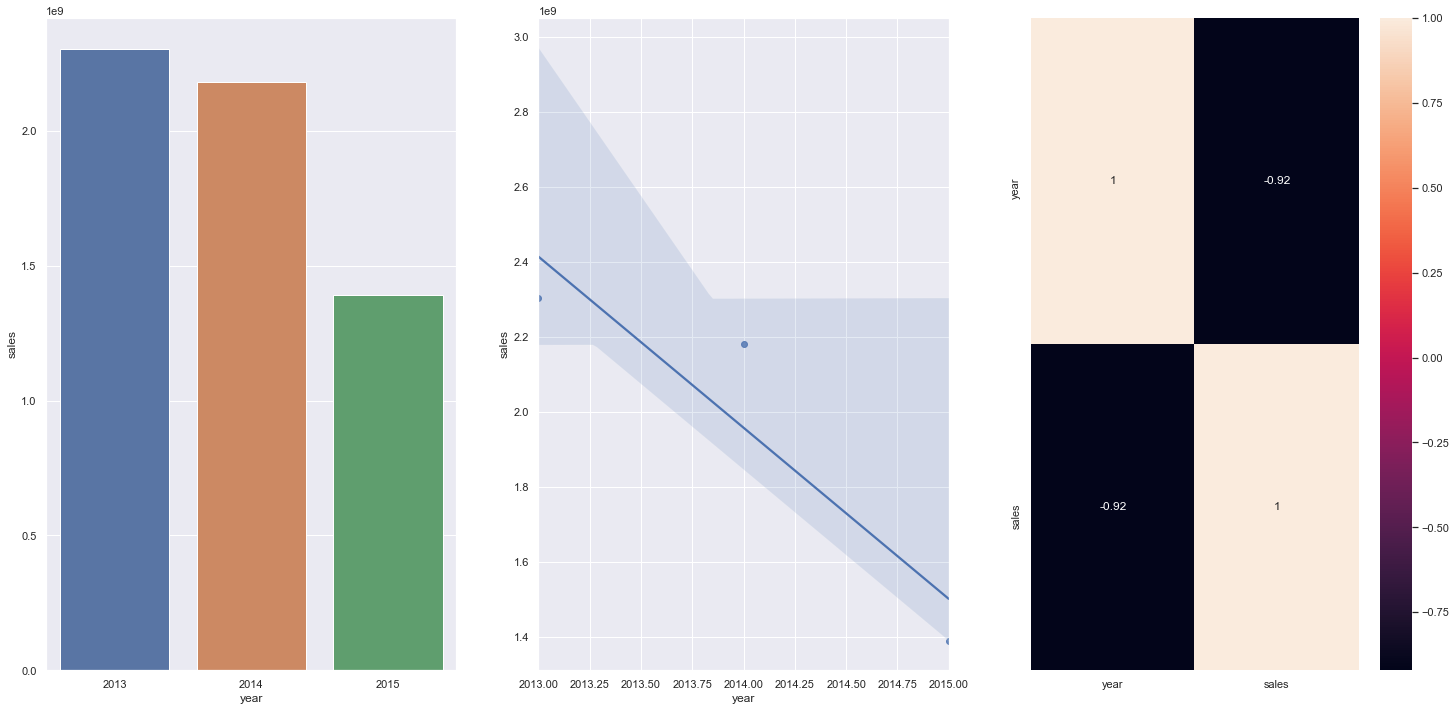

In [51]:
# Como não temos o restante do ano de 2015 no dataset, devemos filtrar apenas até o periodo CHEIO disponível em cada ano para melhor comparação
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no SEGUNDO SEMESTRE do ano.

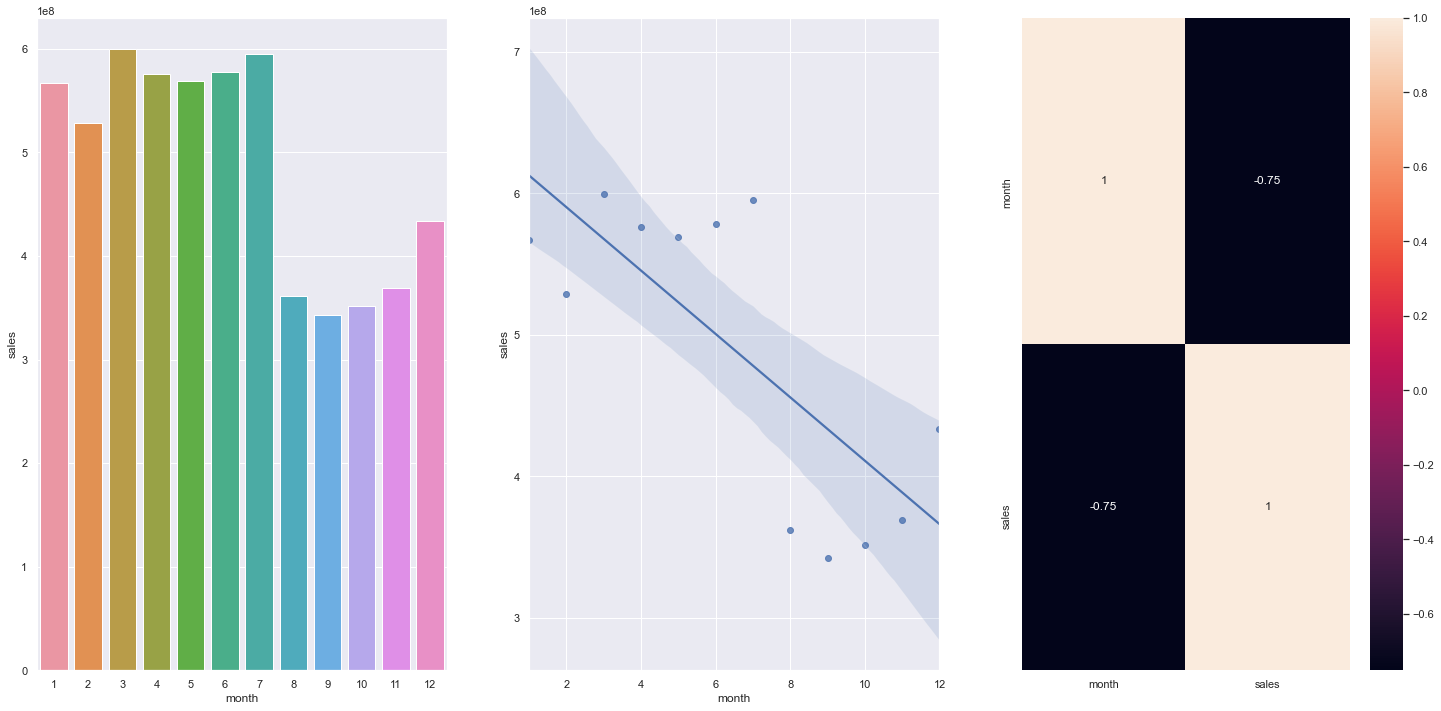

In [52]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem MAIS DEPOIS do DIA 10 de cada mês.

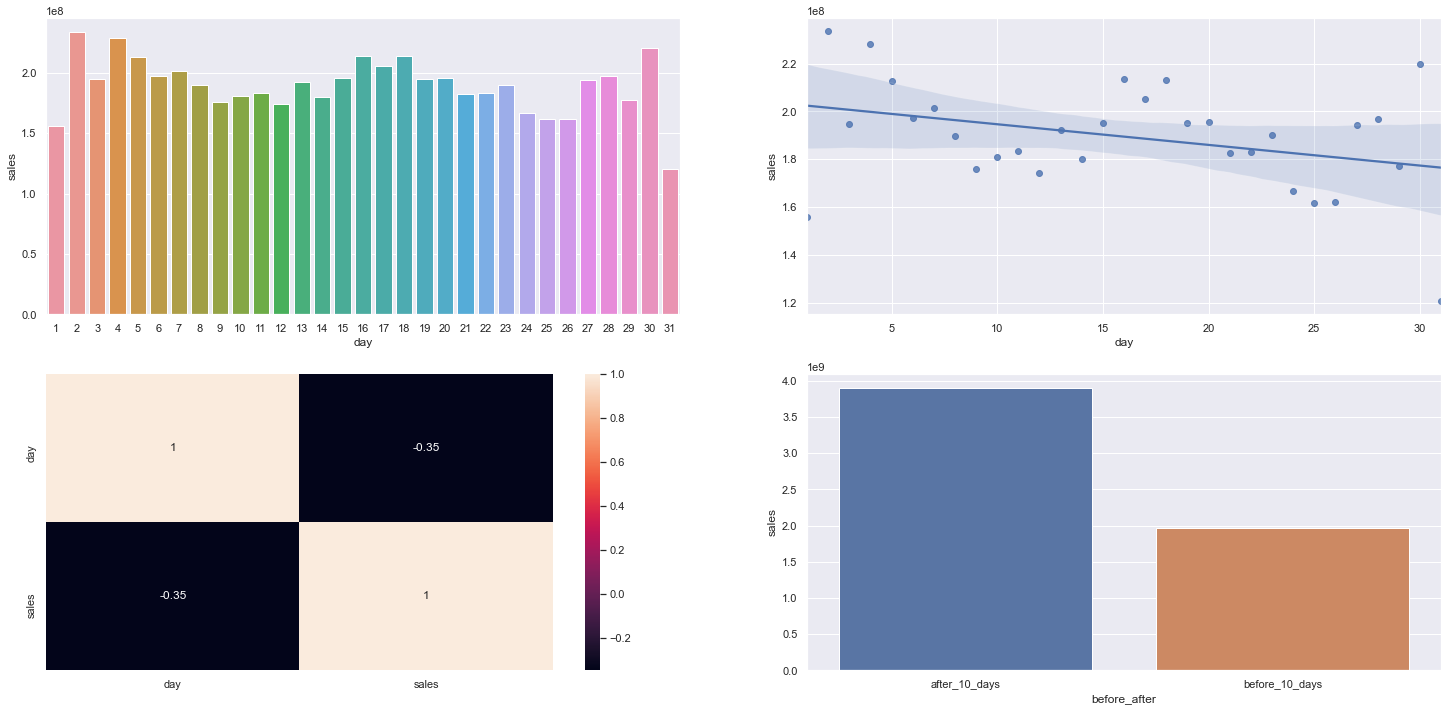

In [53]:
# As lojas vendem menos mas deveriamos olhar melhor essa afirmação, pois existem mais dias depois do dia 10 do que antes.
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby ( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana.

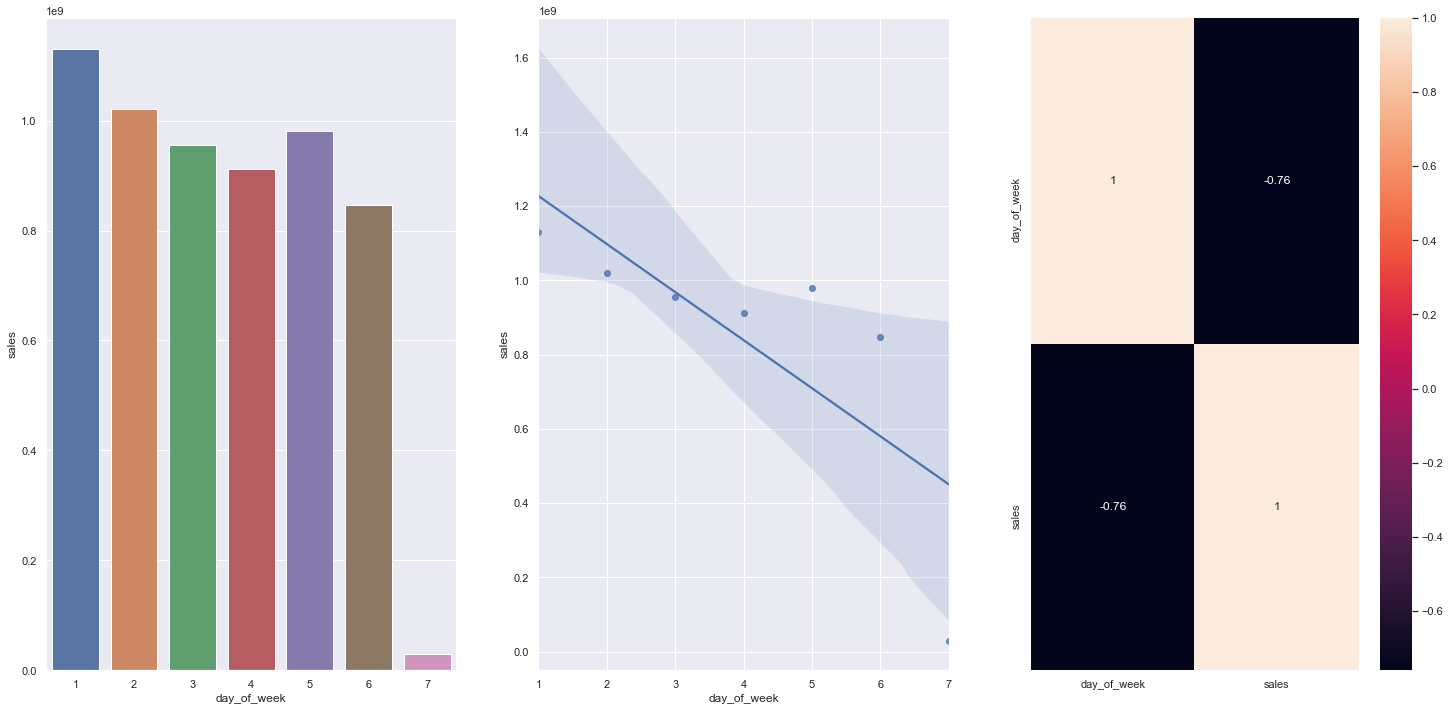

In [54]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os FERIADOS ESCOLARES, exceto os meses de Julho e Agosto.

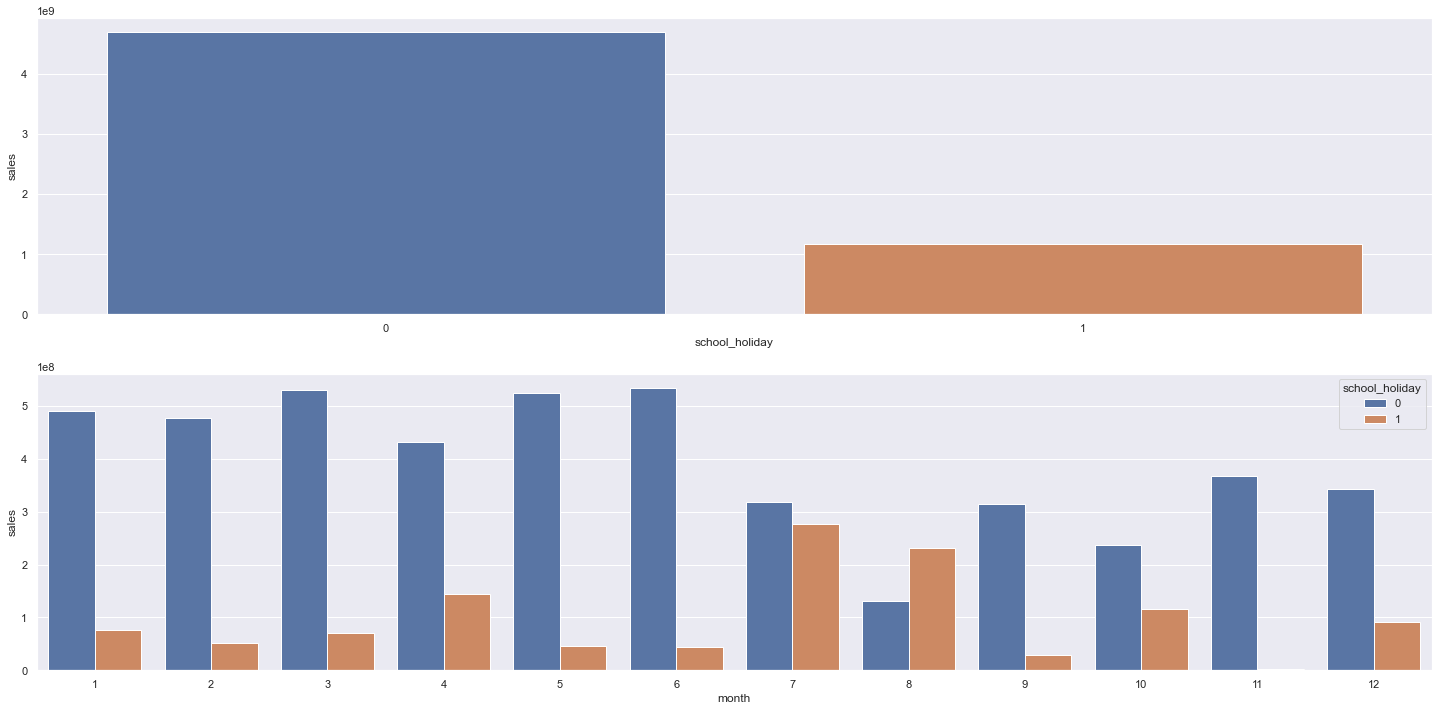

In [55]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipóteses 

In [56]:
from tabulate import tabulate

In [57]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes 

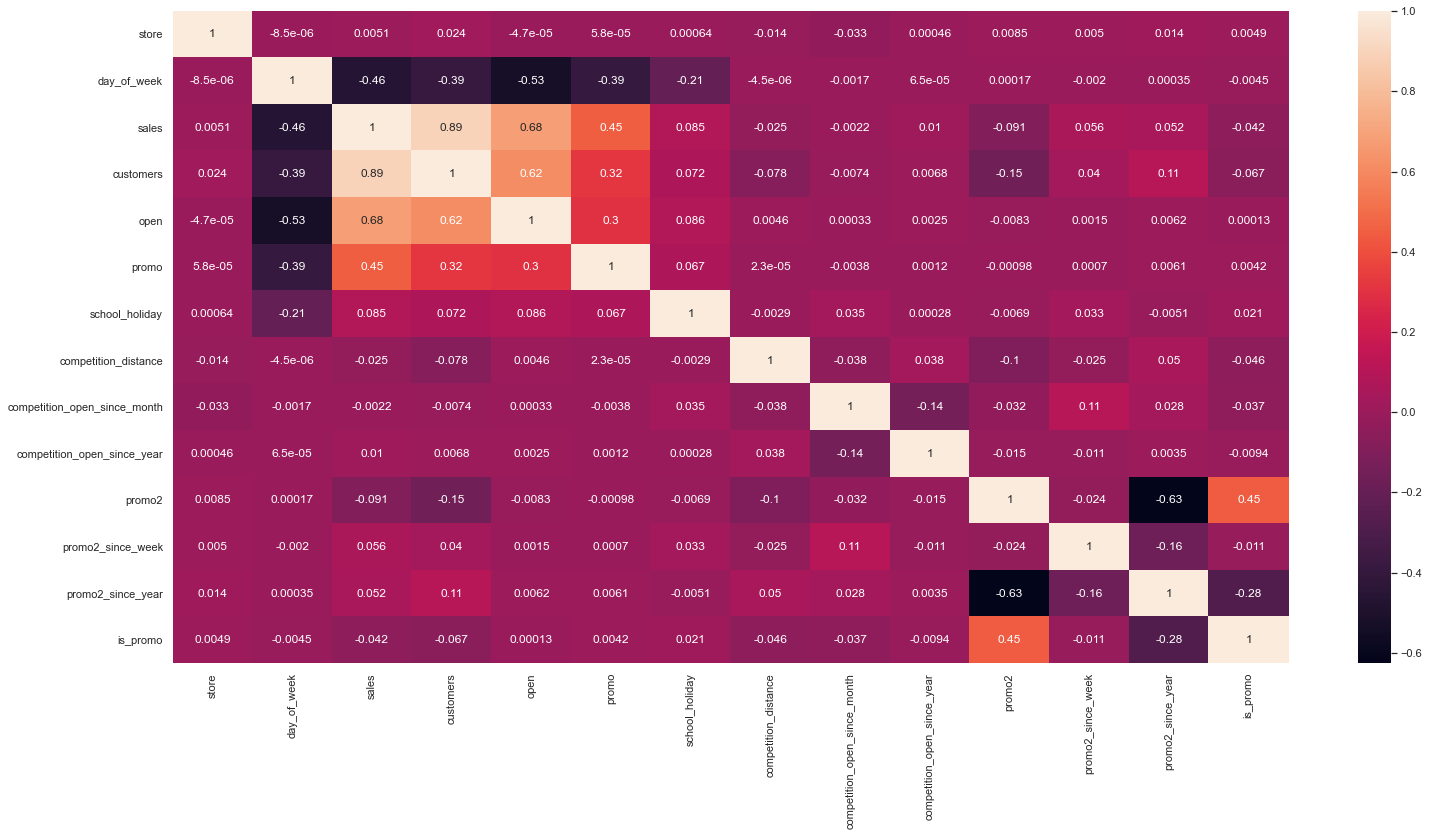

In [58]:
# Gráfico com a correlação entre duas variáveis, que pode variar entre -1 e 1, sendo -1 uma correlação mais forte negativa e 1 uma correlação mais forte positiva
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True);

### 4.3.2. CategoricalAttributes 

In [59]:
# Pegando somente data
a = df4.select_dtypes( include='object' )

# Calculando cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )

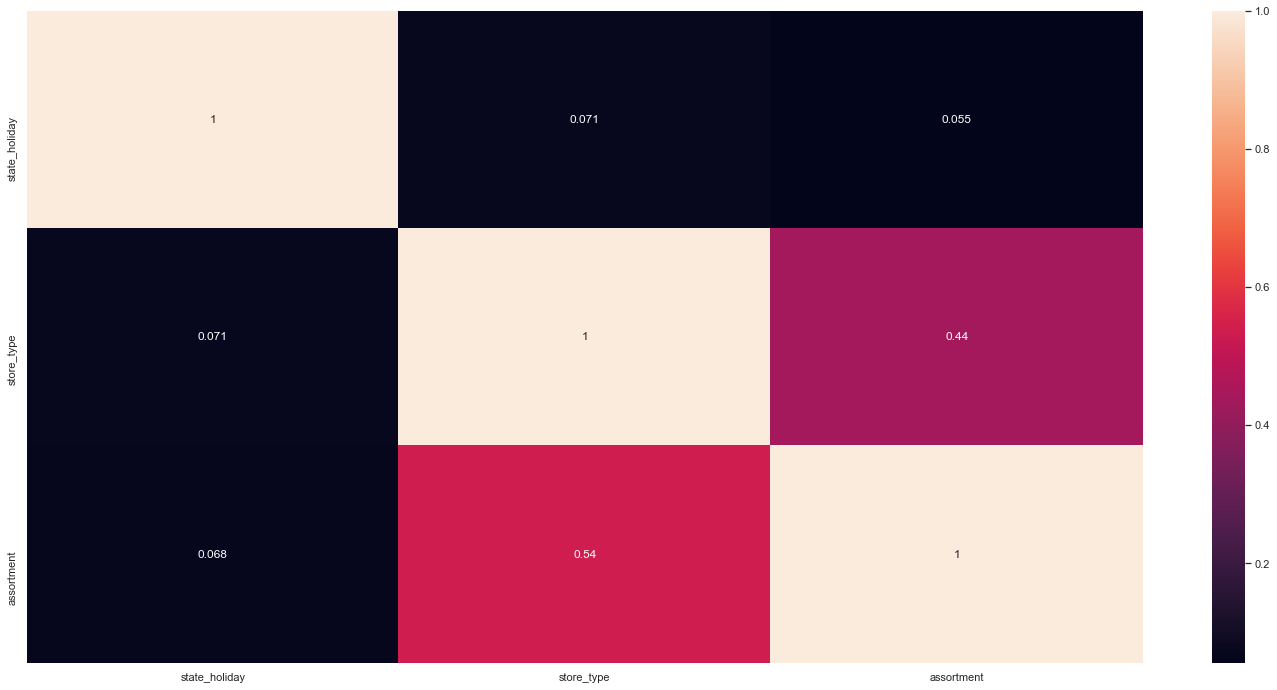

In [60]:
sns.heatmap( d, annot=True);

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [61]:
df5 = df4.copy()

## 5.1. Normalização

In [62]:
# Como não tinha nenhuma variável com distribuição normal, não foi efetuada a normalização de variáveis

## 5.2. Rescaling

In [63]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )


# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. Transformação

### 5.3.1. Encoding

In [64]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extended': 2,
                   'extra': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation 

In [65]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation 

In [66]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 )))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 )))

In [67]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [68]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset 

In [69]:
# Dropando colunas que foram derivadas e originaram outras colunas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [70]:
# Descobrindo a data inicial de 6 semanas antes da última data de venda, essas 6 semanas serão usadas para teste e as datas anteriores são de treino
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=7*6 )

Timestamp('2015-06-19 00:00:00')

In [71]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# Conferindo se as datas estão corretas
print ( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print ( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print ( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print ( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector 

In [72]:
# Training and test for boruta, ele não aceita dataset, então com o .values pegamos apenas os valores
# Também precisamos dropar as colunas date and sales para passar a resposta pronta para o modelo, 
# Já que é a informação que precisamos na resposta
#### X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#### Y_train_n = Y_train.values.ravel()

# Define RandomForestRegressor
#### rf = RandomForestRegressor( n_jobs=-1 )

# Define Boruta Params
#### boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n )


# Comentado para não precisar rodar novamente, pois demora aprox. 1h40m

### 6.2.1. Best Features from Boruta

In [73]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date','sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Colunas não selecionadas pelo boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Features Selection

In [74]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',    
    'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

# final features
#cols_selected_boruta.extend( feat_to_add )

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [80]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [81]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [82]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

#Observar que o RMSE do modelo foi 2662, ou seja, maior que o modelo de média (taxa de erro, significa quanto maior, pior é)

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


### 7.2.1. Linear Regression Model - Cross Validation

In [93]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.72 +/- 295.95,0.3 +/- 0.02,2945.54 +/- 469.14


## 7.3. Linear Regression Regularized Model - Lasso

In [94]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

#Observar que o RMSE do modelo foi 2743, ou seja, o maior entre os modelos lineares (taxa de erro, significa quanto maior, pior é)

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.398669,0.289252,2743.459417


### 7.3.1. Lasso - Cross Validation

In [95]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.17 +/- 506.07


## 7.4. Random Forest Regressor

In [84]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.159116,0.099949,1012.346425


### 7.4.1. Random Forest Regressor - Cross Validation

In [96]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.82 +/- 220.62,0.12 +/- 0.02,1258.21 +/- 321.2


## 7.5. XGBoost Regressor

In [97]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.450741,0.949443,7330.726986


### 7.5.1. XGBoost Regressor - Cross Validation

In [98]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.2 +/- 588.62,0.95 +/- 0.0,7715.18 +/- 689.48


## 7.6. Compare Models Performance 

### 7.6.1 Single Performance

In [111]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.159116,0.099949,1012.346425
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1861.127229,0.291652,2662.291292
0,Linear Regression - Lasso,1891.398669,0.289252,2743.459417
0,XGBoost Regressor,6683.450741,0.949443,7330.726986


### 7.6.2 Real Performance - Cross Validation

In [120]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.72 +/- 295.95,0.3 +/- 0.02,2945.54 +/- 469.14
0,Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.17 +/- 506.07
0,Random Forest Regressor,838.82 +/- 220.62,0.12 +/- 0.02,1258.21 +/- 321.2
0,XGBoost Regressor,7049.2 +/- 588.62,0.95 +/- 0.0,7715.18 +/- 689.48
